# Problem 1 - selecting the right bandwidth

In this problem we will try out band-width selection in two steps. 

## Preparation: Loading of packages and data

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.neighbors import KernelDensity

%matplotlib inline

In [4]:
def read_bh_masses():
    """
    Read in black hole masses from CSV file
    """
    
    fname = '../Datafiles/joint-bh-mass-table.csv'
    t = Table().read(fname)
    return t

In [5]:
t_bh = read_bh_masses()

a) Select the best band-width by linear search.

In [6]:
def show_one_bandwidth(t, bw, what='MBH', xmin=0, xmax=70):
    """
    Show the KDE estimate of the masses with one band-width
    """
    
    X = t[what][:, np.newaxis]
    kde = KernelDensity(bandwidth=bw, kernel='gaussian').fit(X)
    
    xgrid = np.linspace(xmin, xmax, 200)
    ln_p_bh = kde.score_samples(xgrid[:, np.newaxis])
    p_bh = np.exp(ln_p_bh)
    
    h = plt.hist(t[what], normed='area')
    plt.plot(xgrid, p_bh)
    plt.title("Bandwidth={0}".format(bw))
    plt.xlabel(r'$M_{BH}$')
    plt.ylabel(r'$P(M_{BH})$')
    
    return kde

def score_one_bandwidth(t, bw, kernel='gaussian'):
    """
    Fit a KDE and get its score on the fitted sample.
    
    It returns the log likelihood of the data.
    """
    X = t['MBH'][:, np.newaxis]
    kde = KernelDensity(bandwidth=bw, kernel=kernel).fit(X)
    score = kde.score(X)
    
    return score

def score_many_bandwidths(t, kernel='gaussian', bws=None):
    """
    Fit many bandwidths
    """
    if bws is None:
        bws = np.linspace(1, 7.0, 100)
        
    scores = np.zeros_like(bws)
    for i, bw in enumerate(bws):
        scores[i] = score_one_bandwidth(t, bw, kernel=kernel)
    
    return bws, scores
    

In [7]:
bws, scores = score_many_bandwidths(t_bh)

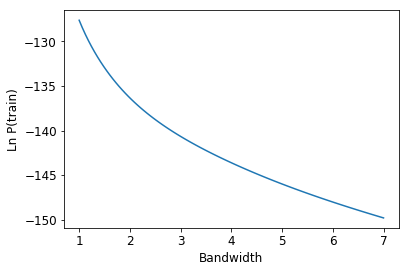

In [8]:
plt.plot(bws, scores)
plt.xlabel('Bandwidth')
plt.ylabel('Ln P(train)')

b) Use cross-validation to find the optimal bandwidth.

We do this manually using `KFold` and then I'll show `GridSearchCV` at the end.

In [9]:
def cv_bh_masses(x, bws, kernel='gaussian', plot=False, n_splits=10):
    """
    This calculates leave-one-out cross validation. 
    
    Parameters: 
       x: The values to do cross-validation over. 
       bws: The band-width range to explore
       
    Keyword parameters:
       kernel: The kernel to use. Must be one supported by 
               sklearn.neighbors.KernelDensity. Default: 'gaussian'
     n_splits: The number of splits to use for the cross-validation. 
               Recommended values is 5-10. Default: 10
         plot: Set this to create a grid of test & training samples. This
               is mostly useful for debugging and does not lead to pretty results

    Returns:
         cv_1: The cross-validation scores (log likelihoods) of each bandwidth tried.
    
    """

    # Get the number of bandwidths to check and the number of objects
    N_bw = len(bws)
    N = len(x)
    cv_1 = np.zeros(N_bw)
    
    if x.ndim == 1:
        X = x[:, np.newaxis]
    else:
        X = x
    
    # If plotting is requested, set up the plot region
    if plot:
        fig, axes = plt.subplots(N_bw, np.ceil(N/n_splits), figsize=(15, 8))
        xplot = np.linspace(0, 70, 1000)

    # Loop over each band-width and calculate the probability of the 
    # test set for this band-width
    for i, bw in enumerate(bws):
    
        # I will do N-fold CV here. This divides X into N_folds
        kf = KFold(n_splits=n_splits)

        # Initiate - lnP will contain the log likelihood of the test sets
        # and i_k is a counter for the folds that is used for plotting and
        # nothing else..
        lnP = 0.0
        i_k = 0
                                 
        # Loop over each fold
        for train, test in kf.split(X):
            x_train = X[train, :]
            x_test = X[test, :]
            
            # Create the kernel density model for this bandwidth and fit
            # to the training set.
            kde = KernelDensity(kernel=kernel, bandwidth=bw).fit(x_train)
                                 
            # score evaluates the log likelihood of a dataset given the fitted KDE.
            log_prob = kde.score(x_test)
            
            if plot:
                # Show the tries
                ax = axes[i][i_k]

                # Note that the test sample is hard to see here.
                hist(x_train, bins=10, ax=ax, color='red')
                hist(x_test, bins=10, ax=ax, color='blue')
                ax.plot(xplot, np.exp(kde.score_samples(xplot[:, np.newaxis])))
                i_k += 1
            

            lnP += log_prob
            
        # Insert the log likelihood          
        cv_1[i] = lnP
        
    return cv_1


In [10]:
cv = cv_bh_masses(t_bh['MBH'], bws)

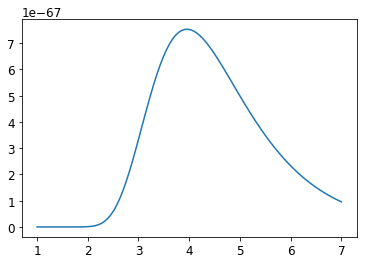

In [11]:
plt.plot(bws, np.exp(cv))

In [12]:
print "The best bandwidth = {0}".format(bws[np.argmax(cv)])

The best bandwidth = 3.9696969697


KernelDensity(algorithm='auto', atol=0, bandwidth=3.97, breadth_first=True,
       kernel='gaussian', leaf_size=40, metric='euclidean',
       metric_params=None, rtol=0)

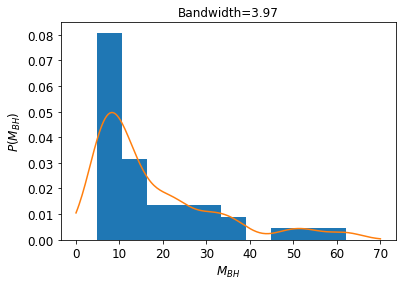

In [13]:
show_one_bandwidth(t_bh, 3.97)

# Problem 2 - neutron stars

The file `pulsar_masses.vot` contains masses of pulsars from Özel & Freire 2016, Annual Reviews of Astronomy and Astrophysics, taken from the [associated web page](http://xtreme.as.arizona.edu/NeutronStars/). 

On October 15, 2017, the LIGO/Virgo consortium and host of ground- and space-based observatories announced the discovery of an optical counter-part to the gravitational wave source GW170817. The two neutron stars that are thought have merged to produce the gravitational wave signal, have estimated masses of $M_1 = 1.81 \,\mathrm{M}_\odot$ and $M_2=1.11\,\mathrm{M}_\odot$. 
  
  a) Use the pulsar mass catalogue to estimate the likelihood of finding a neutron star with $M>1.8\,\mathrm{M}_\odot$.

  b) Actually the mass estimates are ranges, and the masses were $M_1\in [1.36, 2.26]$ and $M_2 \in [0.86, 1.36]$. What are the likelihoods of those mass ranges and the likelihood of the binary?
  
  c) There are many assumptions made that I did not spell out - make a list of some that you worry about.

In [14]:
def read_NS_masses():
    """
    Read in neutron star masses from VOT file
    """
    
    fname = '../Datafiles/pulsar_masses.vot'
    t = Table().read(fname)
    return t

## a) 

To solve this, we need the likelihood distribution of neutron star masses, $P\left(M_{NS})\right)$. The information we have available is the distribution of masses of neutron stars in the indicated paper. To estimate $P(M_{NS})$ we then use kernel density estimation. The first step then is to estimate the bandwidth of the kernel density estimate.


In [15]:
# First, read the masses in
t_NS = read_NS_masses()
t_NS.colnames

['Mass', 'dMlow', 'dMhigh', 'Category', 'Order', 'Name']

In [16]:
# Find the range of masses to consider
np.min(t_NS['Mass']), np.max(t_NS['Mass'])

(0.95099998, 2.6340001)

In [17]:
# We can use the same cross-validation technique as above here, just changing the band-widths to consider
bws_ns = np.linspace(0.05, 0.5, 100)
cv = cv_bh_masses(t_NS['Mass'], bws_ns)

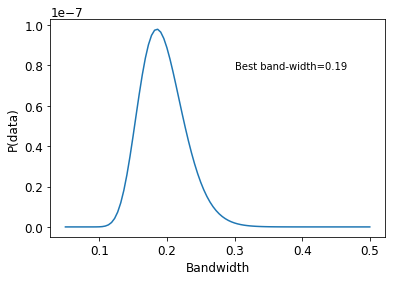

In [18]:
P_cv = np.exp(cv)
plt.plot(bws_ns, P_cv)
plt.text(0.3, 0.8*np.max(P_cv), "Best band-width={0:.2f}".format(bws_ns[np.argmax(P_cv)]))
plt.xlabel('Bandwidth')
plt.ylabel('P(data)')

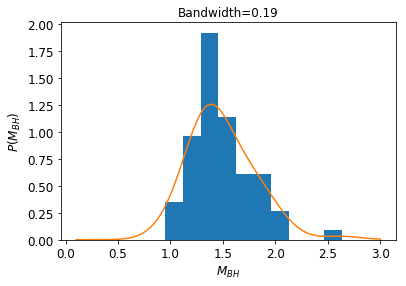

In [19]:
kde = show_one_bandwidth(t_NS, 0.19, what='Mass', xmin=0.1, xmax=3.0)

Now, to solve a (and b) we want to integrate the resulting KDE estimate. To do that we can first evaluate it on a fine grid and integrate.

In [20]:
def p_of_distribution(kde, xmin=1.0, xmax=None):
    """
    Evaluate a KDE over a region and integrate up.
    """
    if xmax is None:
        xmax = 5.0 # used as a practical maximum
    
    # This does the whole grid
    xgrid = np.linspace(0.0, 5.0, 1000)
    ln_p_ns = kde.score_samples(xgrid[:, np.newaxis])
    p_ns = np.exp(ln_p_ns)
    
    # Integrate this to get the normalisation
    norm = np.trapz(p_ns, xgrid)
    
    # Then the subrange
    xint = np.linspace(xmin, xmax, 1000)
    p_int = np.exp(kde.score_samples(xint[:, np.newaxis]))
    I1 = np.trapz(p_int, xint)
    
    return I1, norm
    
    
    
    

In [21]:
I1, norm = p_of_distribution(kde, xmin=1.8)

In [22]:
print "The likelihood of finding a neutron star with M > 1.8={0:.3f}".format(I1/norm)

The likelihood of finding a neutron star with M > 1.8=0.176


In [23]:
I_range1, norm = p_of_distribution(kde, xmin=1.36, xmax=2.26)
I_range2, norm = p_of_distribution(kde, xmin=0.86, xmax=1.36)

In [24]:
print "P([1,36, 2.26]) = {0:.3f},   P([0.86, 1.36] = {1:.3f})".format(I_range1/norm,
                                                                      I_range2/norm)

P([1,36, 2.26]) = 0.598,   P([0.86, 1.36] = 0.360)


In [25]:
print "The likelihood of the binary={0:.3f}".format(I_range1*I_range2/norm**2)

The likelihood of the binary=0.215


### c) Some assumptions made

* I have assumed that the neutron star masses in the file are representative of the underlying population of neutron stars. This might be fair assumption but that is not obvious.
* I have assumed that the binary neutron stars have the same mass distribution as single neutron stars. 
* I have assumed uncertainties on the masses are negligible (not a terribly good assumption).

# Problem 3 - How many peaks?

There are different ways to answer this problem. Here I will use Gaussian Mixture Models. And I'll also need a pickle loader.

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
import cPickle
import sys


def pickle_from_file(fname):

    try:
        fh = open(fname, 'r')
        data = cPickle.load(fh)
        fh.close()
    except:
        print "Loading pickled data failed!", sys.exc_info()[0]
        data = None

    return data


As we will explore different Gaussian mixtures below, it is useful to define a small routine to plot Gaussian Mixtures.

In [27]:
def plot_mixture(X, M_best, xmin=-15, xmax=15, title='Best-fit Mixture'):
    """
    A very simple plot of training data X and the Gaussian mixture m, showing the
    individual components with a dashed line.
    """

    # The x values we want to evaluate the model on.
    xplot = np.linspace(xmin, xmax, 1000)[:, np.newaxis]

    # Evaluate the mixture model at these x-values.
    logprob = M_best.score_samples(xplot)
    p_component = M_best.predict_proba(xplot)
    # Convert to an actual probability. First the overall
    pdf = np.exp(logprob)

    # Then the individual components.
    pdf_individual = p_component * pdf[:, np.newaxis]

    plt.hist(X, 30, normed=True, histtype='stepfilled', alpha=0.4)
    plt.plot(xplot, pdf, '-k')
    plt.plot(xplot, pdf_individual, '--k')
    ax = plt.gca()
    plt.text(0.04, 0.96, title,
             ha='left', va='top', transform=ax.transAxes)
    plt.xlabel('$x$')
    plt.ylabel('$p(x)$')
  
    


Ok, so let us get the data:

In [28]:
x = pickle_from_file('../Datafiles/mysterious-peaks.pkl')
X = x[:, np.newaxis]

We then fit this dataset using a different number of components. I store each model fit in a list since I will need them later

In [29]:
# fit models with 1-10 components
N = range(1, 11)
models = [None for i in N]

for i, n in enumerate(N):
    models[i] = GaussianMixture(n).fit(X)

For simplicity I will use AIC and BIC to choose the best fit. This is done as follows

In [30]:
# compute the AIC and the BIC
AIC = [m.aic(X) for m in models]
BIC = [m.bic(X) for m in models]


print "The minimum number of components according to AIC is {0}".format(N[np.argmin(AIC)])
print "The minimum number of components according to BIC is {0}".format(N[np.argmin(BIC)])

The minimum number of components according to AIC is 8
The minimum number of components according to BIC is 7


Strangely enough the AIC values tend to vary a bit. With the old GMM package the number of best-fit components were 3 but now it tends to land between 7 and 9 for different runs. The reason for this variability is because the curve is essentially flat for 7 or more components.

Armed with this we can now plot the best-fit models using the `plot_mixture` function from above.

In [31]:
M_best_AIC = models[np.argmin(AIC)]
M_best_BIC = models[np.argmin(BIC)]

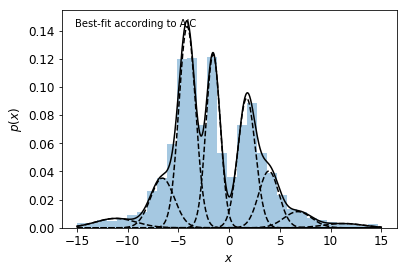

In [32]:
plot_mixture(X, M_best_AIC, title='Best-fit according to AIC')

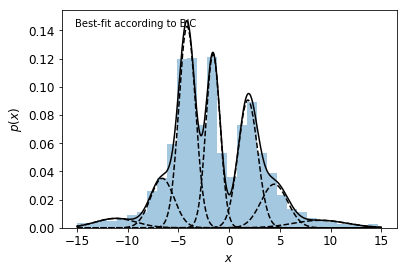

In [33]:
plot_mixture(X, M_best_BIC, title='Best-fit according to BIC')

It is also instructive to see the AIC and BIC curves.

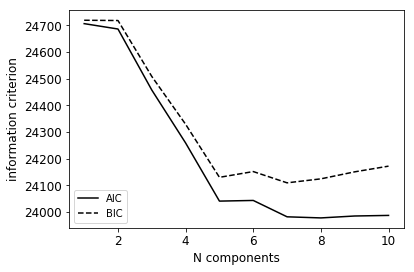

In [34]:
plt.plot(N, AIC, '-k', label='AIC')
plt.plot(N, BIC, '--k', label='BIC')
plt.xlabel('N components')
plt.ylabel('information criterion')
plt.legend(loc=3)


So in this case both AIC and BIC agree that the number of peaks is quite large. But if you look at the data you see that there is actually three peaks. So what gives? 

The data were actually created from five distributions with different peaks. There are four Cauchy distributions, which have very wide tails, and one normal distribution. But the GMM assumes that the data consists of normal distributions so to compensate for the very wide tails of the Cauchy distribution, we need two extra normal components (those seen at -12 and 10 respectively), in addition to other five distributions correctly found.

In the plot below I show the actual locations that were used. The Cauchy distribution centres are shown in red and the normal distribution as green. So you can see that on the left side the peaks are not well localised in this case

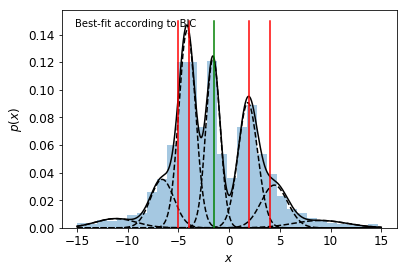

In [35]:
plot_mixture(X, M_best_BIC, title='Best-fit according to BIC')
plt.plot([-5, -5], [0, 0.15], color='red')
plt.plot([-4, -4], [0, 0.15], color='red')
plt.plot([-1.5, -1.5], [0, 0.15], color='green')
plt.plot([2, 2], [0, 0.15], color='red')
plt.plot([4, 4], [0, 0.15], color='red')

# Problem 4. The great wall of the SDSS.

In [36]:
# I will use the KernelDensity class from Scikit-learn rather than the astroML implementation
# because in the documentation of that function they recommend Scikit-learn.
from sklearn.neighbors import KernelDensity

from astroML.datasets import fetch_great_wall
from matplotlib.colors import LogNorm

In [37]:
#------------------------------------------------------------
# Fetch the great wall data
X = fetch_great_wall()

In [38]:
# Run the fit
kde = KernelDensity(5, kernel='gaussian').fit(X)
kde_th = KernelDensity(5, kernel='tophat').fit(X)
kde_exp = KernelDensity(5, kernel='exponential').fit(X)
kde_ep = KernelDensity(5, kernel='epanechnikov').fit(X)

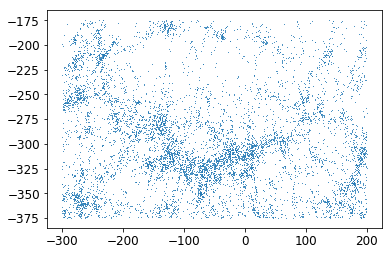

In [39]:
# Plot the raw data.
plt.scatter(X[:, 1], X[:, 0], s=1, lw=0)

In [40]:
# Create  the grid on which to evaluate the results
Nx = 50
Ny = 125
xmin, xmax = (-375, -175)
ymin, ymax = (-300, 200)
Xgrid = np.vstack(map(np.ravel, np.meshgrid(np.linspace(xmin, xmax, Nx),
                                            np.linspace(ymin, ymax, Ny)))).T

In [41]:
xgrid = np.linspace(xmin, xmax, Nx)
ygrid = np.linspace(ymin, ymax, Ny)
mesh = np.meshgrid(xgrid, ygrid)

In [42]:
tmp = map(np.ravel, mesh)
Xgrid = np.vstack(tmp).T

### Gaussian kernel

In [43]:
# Evaluate the KDE on the grid
log_dens = kde.score_samples(Xgrid)
dens1 = X.shape[0] * np.exp(log_dens).reshape((Ny, Nx))

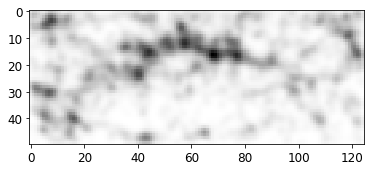

In [44]:
plt.imshow(dens1.T, cmap=plt.cm.binary)

### Top-hat

In [45]:
log_dens_th = kde_th.score_samples(Xgrid)
dens_th = np.exp(log_dens_th).reshape((Ny, Nx))

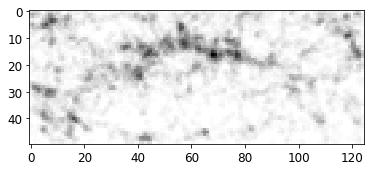

In [46]:
plt.imshow(dens_th.T, cmap=plt.cm.binary)

### Exponential kernel

In [47]:
log_dens_exp = kde_exp.score_samples(Xgrid)
dens_exp = np.exp(log_dens_exp).reshape((Ny, Nx))

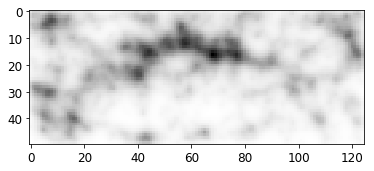

In [48]:
plt.imshow(dens_exp.T, cmap=plt.cm.binary)

### Epanechnikov kernel

In [49]:
log_dens_ep = kde_ep.score_samples(Xgrid)
dens_ep = np.exp(log_dens_ep).reshape((Ny, Nx))

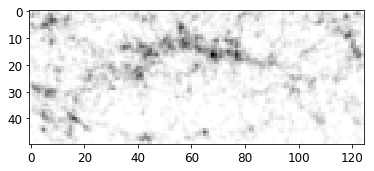

In [50]:
plt.imshow(dens_ep.T, cmap=plt.cm.binary)

### 4b 
Cross-validation

In [58]:
from sklearn.model_selection import KFold

def cv1(x, bws, model='gaussian', plot=False, n_folds=10):
    """
    This calculates the leave-one-out cross validation. If you set 
    plot to True, then it will show a big grid of the test and training
    samples with the KDE chosen at each step. You might need to modify the 
    code if you want a nicer layout :)
    """

    # Get the number of bandwidths to check and the number of objects
    N_bw = len(bws)
    N = len(x)
    cv_1 = np.zeros(N_bw)
    
    # If plotting is requested, set up the plot region
    if plot:
        fig, axes = plt.subplots(N_bw, np.ceil(N/n_folds), figsize=(15, 8))
        xplot = np.linspace(-3, 8, 1000)

    # Loop over each band-width and calculate the probability of the 
    # test set for this band-width
    for i, bw in enumerate(bws):
    
        # I will do N-fold CV here. This divides X into N_folds
        kf = KFold(n_splits=n_folds)

        # Initiate - lnP will contain the log likelihood of the test sets
        # and i_k is a counter for the folds that is used for plotting and
        # nothing else..
        lnP = 0.0
        i_k = 0
                                 
        # Loop over each fold
        for train, test in kf.split(x):
            x_train = x[train, :]
            x_test = x[test, :]
            
            # Create the kernel density model for this bandwidth and fit
            # to the training set.
            kde = KernelDensity(kernel=model, bandwidth=bw).fit(x_train)
                                 
            # score evaluates the log likelihood of a dataset given the fitted KDE.
            log_prob = kde.score(x_test)
            
            if plot:
                # Show the tries
                ax = axes[i][i_k]

                # Note that the test sample is hard to see here.
                hist(x_train, bins=10, ax=ax, color='red')
                hist(x_test, bins=10, ax=ax, color='blue')
                ax.plot(xplot, np.exp(kde.score_samples(xplot[:, np.newaxis])))
                i_k += 1
            

            lnP += log_prob
            
        # Calculate the average likelihood          
        cv_1[i] = lnP/N
        
    return cv_1


In [54]:
from sklearn.model_selection import GridSearchCV

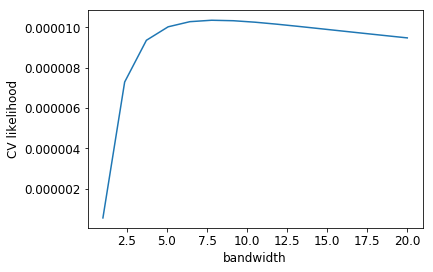

In [63]:
bws = np.linspace(1, 20, 15)
cv = cv1(X, bws)

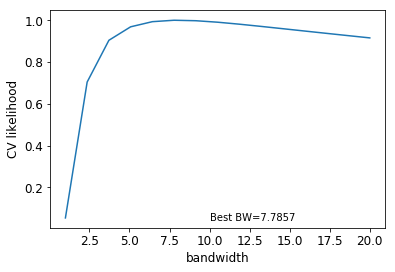

In [64]:
plt.plot(bws, np.exp(cv-np.max(cv)))
plt.xlabel('bandwidth')
plt.ylabel('CV likelihood')
plt.text(10.0, 0.04, 'Best BW={0:.4f}'.format(bws[np.argmax(cv)]))

This gives us an estimate of the best kernel band-width of 7.786. That is a useful start. To get a better solution you could now interpolate the data above and find the maximum of that

In [65]:
bw_big = np.linspace(1, 20, 1000)
cv_big = np.interp(bw_big, bws, cv)
print "The linearly interpolated maximum is={0:.4f}".format(bw_big[np.argmax(cv_big)])

The linearly interpolated maximum is=7.7898


Now, that used linear interpolation - it might be better to use a higher order interpolation - we do this using `scipy.interpolate`.

In [67]:
from scipy import interpolate
f = interpolate.interp1d(bws, cv, kind=2)
cv_big2 = f(bw_big)
print "The quadratically interpolated maximum is={0:.4f}".format(bw_big[np.argmax(cv_big2)])

The quadratically interpolated maximum is=8.0561
